## Use of AI Declaration

I completed the project with assistance from AI.  
Here is the link to the conversation: [ChatGPT Conversation](https://chatgpt.com/share/68e126d3-e090-800a-9205-ee94a1be09ca)


## Step 1: setup (imports, config and helpers (see Final_project_functions for helpers :))

In [1]:
#Imports and helpers
import warnings, sys, time, json, importlib, os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import quantstats as qs

from sklearn import __version__ as skl_version
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.inspection import permutation_importance

# Classification models (Labs 3–7)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)

# Regression models (Labs 2–4)
from sklearn.linear_model import LinearRegression, ElasticNet

# Metrics
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    mean_squared_error, r2_score, precision_recall_curve, roc_curve,
    classification_report, confusion_matrix
)

# Custom functions
import Final_project_functions as F

# Autoreload 
%load_ext autoreload
%autoreload 2

importlib.reload(F)

# project config (I can change this how i like, my reasoning is in the report)
CONFIG = {
    "TICKER": "AAPL",
    "START": "2005-01-01",
    "END": "2025-09-24" ,                 
    "FREQ": "W",
    "TEST_YEARS": 3,
    "H": 0.0025,
    "REFIT_METRIC": "average_precision",
    "TX_COST_BPS": 3,
    "ETF_CANDIDATES": ["SPY","QQQ","XLK","VGT","IYW","SMH","SOXX","XLY","XLC"],
    "OUT_DIR": "./outputs",
    "RANDOM_STATE": 42,
}

Path(CONFIG["OUT_DIR"]).mkdir(parents=True, exist_ok=True)

# reproducibilty and display setting
F.set_seeds(CONFIG["RANDOM_STATE"])
np.random.seed(CONFIG["RANDOM_STATE"])
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 100)
warnings.filterwarnings("ignore")

F.print_env_and_config(CONFIG)


Env summary:
  Python       : 3.9.23
  NumPy        : 2.0.2
  Pandas       : 2.3.3
  scikit-learn : 1.6.1
  yfinance     : 0.2.66

CONFIG:
  TICKER: AAPL
  START: 2005-01-01
  END: 2025-09-24
  FREQ: W
  TEST_YEARS: 3
  H: 0.0025
  REFIT_METRIC: average_precision
  TX_COST_BPS: 3
  ETF_CANDIDATES: ['SPY', 'QQQ', 'XLK', 'VGT', 'IYW', 'SMH', 'SOXX', 'XLY', 'XLC']
  OUT_DIR: ./outputs
  RANDOM_STATE: 42


## Step 2: data collection and additional checks 

Daily bars:  5214 | 2005-01-03 -> 2025-09-23
Weekly bars: 1082 | 2005-01-05 -> 2025-09-24


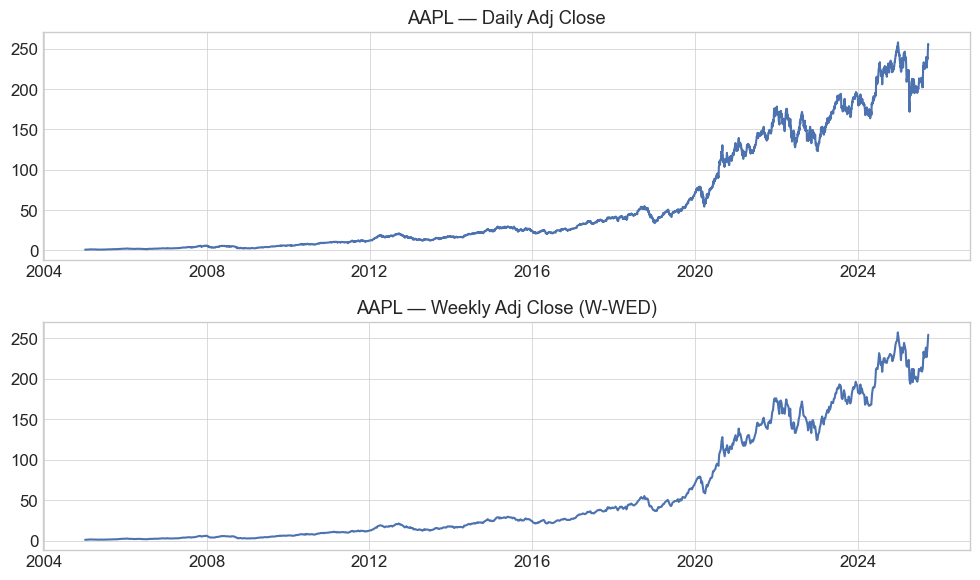


Peer weekly returns (for corr/PCA): (1082, 0) | kept=[] | failed=['SPY', 'QQQ', 'XLK', 'VGT', 'IYW', 'SMH', 'SOXX', 'XLY', 'XLC'] | dropped=[]
Not enough ETFs passed coverage to plot correlation.


In [2]:
#Plot style setups
plt.style.use("seaborn-v0_8-whitegrid")

start = CONFIG["START"]
end   = CONFIG["END"] or datetime.today().strftime("%Y-%m-%d")

# 2.1 AAPL daily to weekly conversion
daily  = F.get_daily(CONFIG["TICKER"], start, end)
weekly = F.to_weekly(daily, rule="W-WED")

# daily log returns (I use these for backtests also)
ret_daily = np.log(daily["Adj Close"]).diff().dropna().to_frame("Ret")

print(f"Daily bars:  {len(daily):4d} | {daily.index.min().date()} -> {daily.index.max().date()}")
print(f"Weekly bars: {len(weekly):4d} | {weekly.index.min().date()} -> {weekly.index.max().date()}")

# Price plots
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=False)
ax[0].plot(daily.index, daily["Adj Close"])
ax[0].set_title(f"{CONFIG['TICKER']} — Daily Adj Close")
ax[1].plot(weekly.index, weekly["Adj Close"])
ax[1].set_title(f"{CONFIG['TICKER']} — Weekly Adj Close (W-WED)")
plt.tight_layout(); plt.show()

# 2.2 Peer ETF scan 

peer_rets = {}  
failed = []
for t in CONFIG["ETF_CANDIDATES"]:
    try:
        peer_rets[t] = weekly_logret_from_ticker(t, start, end)
    except Exception as e:
        failed.append(t)  #This part kept giving me errors in loading soo I asked Chatgpt for help here
                          #it then came up with this for loop for error checking

# Align on AAPL weekly index and drop ETF with poor overlap
peer_ret = pd.concat(peer_rets, axis=1) if len(peer_rets) else pd.DataFrame(index=weekly.index)
peer_ret = peer_ret.reindex(weekly.index)
min_cov = int(0.80 * len(weekly))  # at least 80% coverage
peer_ret = peer_ret.dropna(axis=1, thresh=min_cov)

# Greedy selection ie i keep at most 4 ETFs and I always include SPY if available
# prefer those most correlated with AAPL weekly returns  avoid near duplicates (>0.95 among chosen)
aapl_wr = np.log(weekly["Adj Close"]).diff().dropna()
corr_to_aapl = peer_ret.corrwith(aapl_wr).sort_values(ascending=False)

selected = []
candidates = list(corr_to_aapl.index)
# ensure SPY first if present as sometimes it didnt download properly
if "SPY" in candidates:
    selected.append("SPY")
    candidates.remove("SPY")

for etf in candidates:
    if len(selected) >= 4: break
    ok = True
    for s in selected:
        # measure redundancy with already chosen ETFs
        if peer_ret[[etf, s]].dropna().corr().iloc[0,1] > 0.95:
            ok = False
            break
    if ok:
        selected.append(etf)

dropped = [c for c in peer_ret.columns if c not in selected]
peer_ret = peer_ret[selected]  # keep only chosen

print(f"\nPeer weekly returns (for corr/PCA): {peer_ret.shape} | kept={selected} | failed={failed} | dropped={dropped}")

# Corellation heatmap of the chosen ETFs
if peer_ret.shape[1] >= 2:
    C = peer_ret.corr()
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(C.values, cmap="RdBu_r", vmin=-1, vmax=1)
    ax.set_title("Selected ETFs — Weekly Return Correlation")
    ax.set_xticks(range(len(C.columns))); ax.set_xticklabels(C.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(C.index)));   ax.set_yticklabels(C.index)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
else:
    print("Not enough ETFs passed coverage to plot correlation.")

AAPL_DAILY  = daily
AAPL_WEEKLY = weekly
RET_DAILY   = ret_daily
PEER_RET_W  = peer_ret



## Step 3: Labels & Feature Engineering (weekly) 

Weekly bars: 1082 | Features: (1042, 20) | Pos rate: 0.553 | Range: 2005-10-12 → 2025-09-24


,rsi14,macd_line,macd_sig,macd_hist,atr_pct,sma10_40,bb_z20,mom4,mom12,ret1_lag,vol_z26,vol_chg4,vol_4w,vol_13w,lag2,lag4,mom_vol,rsi_bb,drawdown,skew_13
Date,,,,,,,,,,,,,,,,,,,,
2005-10-12,72.453388,0.108151,0.079565,0.028586,0.211550,0.164611,1.726408,0.080864,0.319377,0.032739,-0.041215,0.180107,0.029501,0.043391,-0.019963,0.018924,0.013526,113.612435,0.000000,1.072634
2005-10-19,61.893756,0.104041,0.084461,0.019581,0.190209,0.167202,0.958960,-0.007283,0.121165,-0.069223,2.106001,0.761854,0.053746,0.050884,0.032739,0.049164,0.013858,125.084141,-0.066881,0.519769
2005-10-26,69.587903,0.113262,0.090221,0.023041,0.190358,0.179223,1.751836,0.052885,0.222279,0.109332,2.113859,0.522994,0.076412,0.047533,-0.069223,-0.019963,0.006165,59.353616,0.000000,0.208802
2005-11-02,71.837264,0.124200,0.097017,0.027184,0.184281,0.187090,1.851736,0.110184,0.277274,0.037336,0.936581,0.240377,0.073430,0.047733,0.109332,0.032739,0.010566,121.906625,0.000000,0.047288
2005-11-09,74.657466,0.138347,0.105283,0.033065,0.187716,0.203471,2.017650,0.127378,0.323512,0.049933,0.769077,0.277164,0.074333,0.046967,0.037336,-0.069223,0.013235,133.023669,0.000000,-0.268372
2005-11-16,74.806369,0.148238,0.113874,0.034364,0.176925,0.219673,1.792622,0.199267,0.242842,0.002666,0.502067,-0.537263,0.044426,0.047007,0.049933,0.109332,0.015194,150.632624,0.000000,-0.263127
2005-11-23,78.853286,0.165889,0.124277,0.041612,0.177402,0.238686,2.176047,0.167376,0.349989,0.077442,-0.063777,-0.613120,0.031026,0.046424,0.002666,0.037336,0.011415,134.099556,0.000000,-0.291824
2005-11-30,80.368838,0.182999,0.136021,0.046978,0.179778,0.262353,2.148098,0.162756,0.358528,0.032715,-0.084382,-0.343319,0.031334,0.043469,0.077442,0.049933,0.016248,171.588483,0.000000,-0.555778
2005-12-07,80.854537,0.196020,0.148021,0.047999,0.169944,0.280362,1.977595,0.123346,0.331589,0.010524,0.021576,-0.251187,0.033575,0.043770,0.032715,0.002666,0.015585,172.640140,0.000000,-0.467064


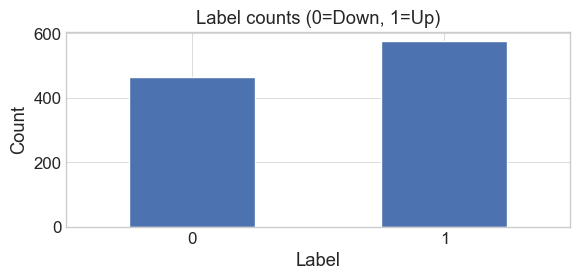

In [3]:
# Data to weekly converion
daily  = F.get_daily(CONFIG["TICKER"], CONFIG["START"], CONFIG["END"])
weekly = F.to_weekly(daily)           # W-WED inside the helper

weekly = F.to_weekly(F.get_daily(CONFIG["TICKER"], CONFIG["START"], CONFIG["END"]))
X_all_w, y_all_w = F.build_weekly_features(weekly, H=CONFIG["H"])

print(
    f"Weekly bars: {len(weekly)} "
    f"| Features: {X_all_w.shape} "
    f"| Pos rate: {y_all_w.mean():.3f} "
    f"| Range: {X_all_w.index.min().date()} → {X_all_w.index.max().date()}"
)
display(X_all_w.head(10))
# histogram plot for labels
plt.figure(figsize=(6,3))
y_all_w.value_counts().sort_index().plot(kind="bar", rot=0)
plt.title("Label counts (0=Down, 1=Up)")
plt.xlabel("Label"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


## Step 4: Split, correlation/VIF prune, scaling and graphs

Train (885, 20) | Test (157, 20) | PosRate train=0.558, test=0.522
Dropped by corr>|0.95|: ['macd_sig']
Shapes after corr prune: (885, 19) (157, 19)
VIF-dropped (>=10): ['rsi14', 'bb_z20', 'mom12']
Shapes after VIF prune: (885, 16) (157, 16)


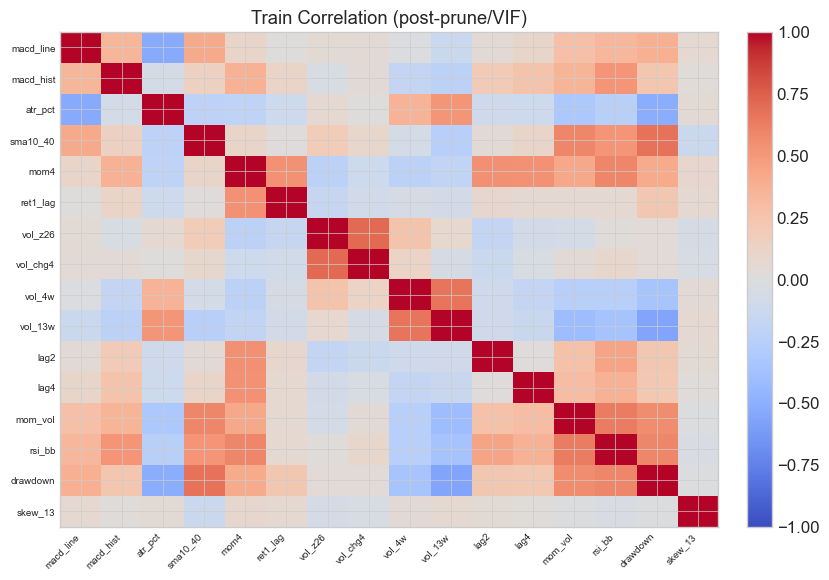

,mean,std,corr_to_Up
vol_z26,-0.0900,1.0402,-0.1093
vol_4w,0.0349,0.0200,-0.0677
mom4,0.0210,0.0898,0.0613
macd_line,1.2048,2.4091,-0.0493
skew_13,-0.1707,0.7175,0.0481
ret1_lag,0.0052,0.0415,0.0374
vol_chg4,-0.0092,0.4159,-0.0356
lag2,0.0052,0.0415,0.0350
rsi_bb,55.3368,75.5504,0.0223
macd_hist,-0.0004,0.7216,-0.0192


In [4]:
# VIF (ChatGPT helped me come up with this, it will skip if not present so less errors)
try:
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    _HAS_SM = True
except Exception:
    _HAS_SM = False

# Build the working DataFrame from Step 3 outputs

X_all_w = X_all_w.sort_index()
y_all_w = y_all_w.sort_index()
if isinstance(y_all_w, pd.DataFrame):
    if "Up" in y_all_w.columns:
        y_all_w = y_all_w["Up"]
    else:
        y_all_w = y_all_w.iloc[:, 0]
y_all_w = y_all_w.astype(int)

data = pd.concat([X_all_w, y_all_w.rename("Up")], axis=1).dropna().sort_index()

# 4.1 time split 
split_date = data.index.max() - pd.DateOffset(years=CONFIG["TEST_YEARS"])
train = data.loc[data.index < split_date].copy()
test  = data.loc[data.index >= split_date].copy()

X_train_val = train.drop(columns="Up")
y_train_val = train["Up"].astype(int)
X_test      = test.drop(columns="Up")
y_test      = test["Up"].astype(int)

print(f"Train {X_train_val.shape} | Test {X_test.shape} | "
      f"PosRate train={y_train_val.mean():.3f}, test={y_test.mean():.3f}")

# 4.2 correlation prune on TRAIN ONLY, this is to avod leakage
C = X_train_val.corr().abs()
upper = C.where(np.triu(np.ones(C.shape), k=1).astype(bool))
drop_corr = [col for col in upper.columns if any(upper[col] > 0.95)]

X_train_val_pruned = X_train_val.drop(columns=drop_corr)
X_test_pruned      = X_test.drop(columns=[c for c in drop_corr if c in X_test.columns], errors="ignore")

print("Dropped by corr>|0.95|:", drop_corr)
print("Shapes after corr prune:", X_train_val_pruned.shape, X_test_pruned.shape)

# 4.3 VIF prune on TRAIN only
vif_drop = []
if _HAS_SM:
    try:
        X1 = X_train_val_pruned.fillna(X_train_val_pruned.median(numeric_only=True))
        while X1.shape[1] > 2:
            Xnp = sm.add_constant(X1).values
            vifs = [variance_inflation_factor(Xnp, i) for i in range(1, Xnp.shape[1])]
            v = pd.Series(vifs, index=X1.columns)
            mx = v.max()
            if mx < 10:
                break
            bad = v.idxmax()
            vif_drop.append(bad)
            X1 = X1.drop(columns=[bad])

        # keep surviving columns and align TEST
        X_train_val_pruned = X_train_val_pruned[X1.columns]
        X_test_pruned = X_test_pruned.reindex(columns=X1.columns)
        print("VIF-dropped (>=10):", vif_drop)
        print("Shapes after VIF prune:", X_train_val_pruned.shape, X_test_pruned.shape)
    except Exception as e:
        print("VIF step skipped due to:", e)
else:
    print("statsmodels not available — skipping VIF step")

# 4.4 scalar definition 
scaler = ColumnTransformer(
    transformers=[("std", StandardScaler(), list(X_train_val_pruned.columns))],
    remainder="drop"
)

# 4.5 correllation heatmap on TRAIN (after prune)
C2 = X_train_val_pruned.corr()
fig, ax = plt.subplots(figsize=(8.5, 6))
im = ax.imshow(C2.values, cmap="coolwarm", vmin=-1, vmax=1, aspect="auto")
ax.set_title("Train Correlation (post-prune/VIF)")
ax.set_xticks(range(len(C2.columns))); ax.set_xticklabels(C2.columns, rotation=45, ha="right", fontsize=7)
ax.set_yticks(range(len(C2.index)));   ax.set_yticklabels(C2.index, fontsize=7)
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()
# Feuture table (TRAIN only, postprune) 
train_cols = list(X_train_val_pruned.columns)

desc = X_train_val_pruned[train_cols].agg(["mean","std"]).T
corr_to_up = pd.concat([X_train_val_pruned[train_cols], y_train_val], axis=1) \
                .corr().loc[train_cols, "Up"].rename("corr_to_Up")

sanity_tbl = desc.join(corr_to_up).sort_values("corr_to_Up", key=np.abs, ascending=False)
display(sanity_tbl.round(4))

# flags
near_zero = X_train_val_pruned[train_cols].std() < 1e-8
if near_zero.any():
    print("Near-zero variance features:", list(near_zero[near_zero].index))


## Step 5: classification (randomized + grid) + regression parity + OOF diags

In [5]:
np.random.seed(CONFIG["RANDOM_STATE"])

# 5.1 Preprocesing the data
pre = ColumnTransformer(
    [
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), list(X_train_val_pruned.columns))
    ],
    remainder="drop"
)

# 5.2 CV and scoring
tscv = TimeSeriesSplit(n_splits=5)          # time-series CV 
kfold = KFold(n_splits=5, shuffle=False)    # KFold for regression parity 
SCORING = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "average_precision": "average_precision",
}
REFIT = CONFIG.get("REFIT_METRIC", "average_precision")  # must be a key in SCORING


# --- Single model: LogReg_poly_saga (best performer) ---

print(f"Positive rate (train): {y_train_val.mean():.4f}")

# Preprocessing (PolynomialFeatures + Scaling)
log_poly_pipe = Pipeline([
    ("pre", ColumnTransformer([
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("sc", StandardScaler())
        ]), list(X_train_val_pruned.columns))
    ], remainder="drop")),
    ("clf", LogisticRegression(
        max_iter=2500, class_weight="balanced", solver="saga",
        random_state=CONFIG["RANDOM_STATE"]
    ))
])

# Parameter grid for tuning
log_poly_space = {
    "clf__penalty": ["l2", "elasticnet"],
    "clf__C": np.logspace(-3, 2, 8),
    "clf__l1_ratio": np.linspace(0, 0.9, 6)
}

# Perform RandomizedSearchCV only for this model
best_search = F.rs(
    "LogReg_poly_saga", log_poly_pipe, log_poly_space,
    X_train_val_pruned, y_train_val,
    cv=tscv,
    scoring=SCORING,
    refit=REFIT,
    n_iter=30,
    random_state=CONFIG["RANDOM_STATE"],
    n_jobs=-1
)

best_model = best_search.best_estimator_
best_params = best_search.best_params_
best_score = best_search.best_score_

print(f"\n[Classification] Using ONLY LogReg_poly_saga with {REFIT} = {best_score:.4f}")
print("Best hyperparameters:", best_params)


Positive rate (train): 0.5582
LogReg_poly_saga: best average_precision = 0.6193

[Classification] Using ONLY LogReg_poly_saga with average_precision = 0.6193
Best hyperparameters: {'clf__penalty': 'l2', 'clf__l1_ratio': np.float64(0.54), 'clf__C': np.float64(0.005179474679231213)}


## Step 5b: OOF diagnostics and threshold selection

OOF ROC-AUC: 0.550 | OOF PR-AUC:  0.595


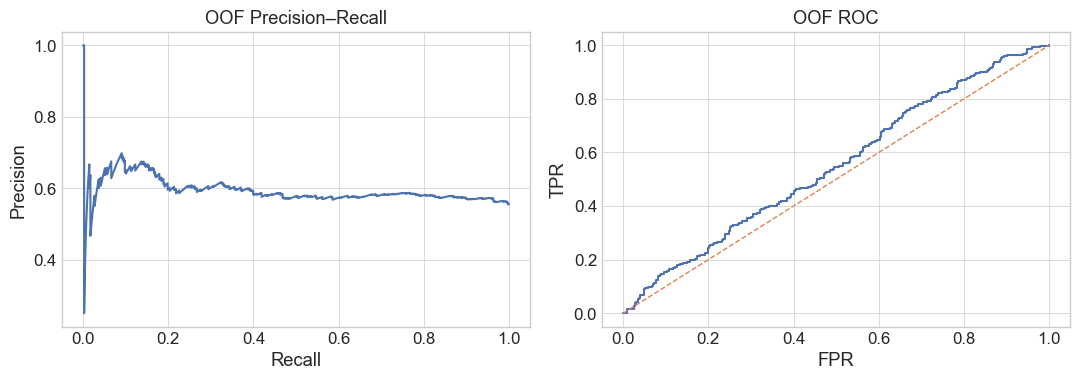

Chosen BEST_THRESHOLD = 0.200 (Sharpe-opt=0.2, F1-opt=0.075)


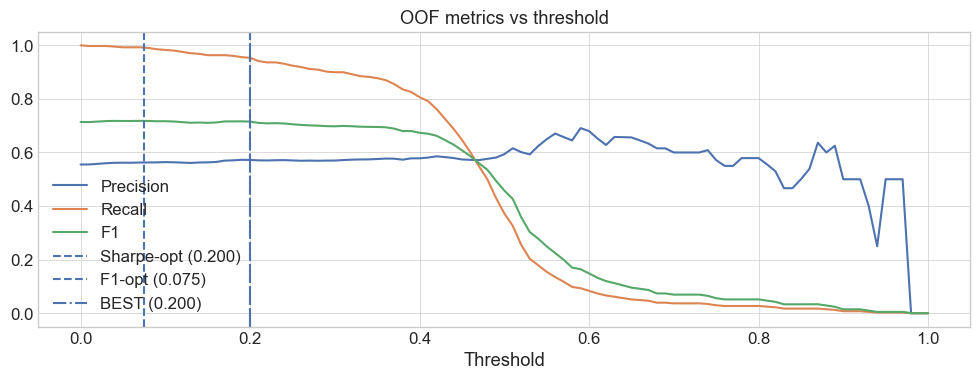

Saved BEST_THRESHOLD to outputs\best_threshold.json


In [6]:
#I split 5 up because when together for some reason the run time was thripled
importlib.reload(F)  # ensure latest utils

# OOF preds
oof_proba_s, y_oof_s = F.time_series_oof_proba(
    best_model, X_train_val_pruned, y_train_val, tscv
)
oof_proba = oof_proba_s.values
y_oof     = y_oof_s.values

print(f"OOF ROC-AUC: {roc_auc_score(y_oof, oof_proba):.3f} | "
      f"OOF PR-AUC:  {average_precision_score(y_oof, oof_proba):.3f}")

# PR/ROC plts
prec, rec, _ = precision_recall_curve(y_oof, oof_proba)
fpr,  tpr,  _ = roc_curve(y_oof, oof_proba)

fig, ax = plt.subplots(1,2, figsize=(11,4))
ax[0].plot(rec, prec); ax[0].set_title("OOF Precision–Recall")
ax[0].set_xlabel("Recall"); ax[0].set_ylabel("Precision")
ax[1].plot(fpr, tpr); ax[1].plot([0,1],[0,1],'--',lw=1)
ax[1].set_title("OOF ROC"); ax[1].set_xlabel("FPR"); ax[1].set_ylabel("TPR")
plt.tight_layout(); plt.show()

# Threshold selection 
# Using RET_DAILY and split_dat.
RET_DAILY_SER = (RET_DAILY["Ret"] if isinstance(RET_DAILY, pd.DataFrame) else RET_DAILY)

thr_info = F.select_thresholds(
    oof_proba_s=oof_proba_s,                # keep as Series
    y_oof_s=y_oof_s,                        # keep as Series
    ret_daily=RET_DAILY_SER,                # SAME returns object as Step 5
    train_end=split_date                    # SAME cutoff as Step 5
)
BEST_THRESHOLD = float(thr_info["best_threshold"])
thr_f1        = float(thr_info.get("thr_f1", np.nan))
thr_sharpe    = float(thr_info.get("thr_sharpe", np.nan))

print(f"Chosen BEST_THRESHOLD = {BEST_THRESHOLD:.3f} "
      f"(Sharpe-opt={thr_sharpe}, F1-opt={thr_f1})")

# Plotting for visual aspect
thr_grid = np.linspace(0.0, 1.0, 101)  # smooth curves for plotting
f1_vals, p_vals, r_vals = [], [], []
for t in thr_grid:
    p_, r_, f1_ = F.f1_at_threshold(oof_proba, y_oof, t)
    p_vals.append(p_); r_vals.append(r_); f1_vals.append(f1_)

fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(thr_grid, p_vals, label="Precision")
ax.plot(thr_grid, r_vals, label="Recall")
ax.plot(thr_grid, f1_vals, label="F1")
if not np.isnan(thr_sharpe):
    ax.axvline(thr_sharpe, ls="--", lw=1.5, label=f"Sharpe-opt ({thr_sharpe:.3f})")
if not np.isnan(thr_f1):
    ax.axvline(thr_f1, ls="--", lw=1.5, label=f"F1-opt ({thr_f1:.3f})")
ax.axvline(BEST_THRESHOLD, ls="-.", lw=1.5, label=f"BEST ({BEST_THRESHOLD:.3f})")
ax.set_title("OOF metrics vs threshold"); ax.set_xlabel("Threshold"); ax.legend()
plt.tight_layout(); plt.show()

# make sure step 6 runs smoothly as i kept having issues here, ChatGPT helped with this solution
from pathlib import Path
Path(CONFIG["OUT_DIR"]).mkdir(parents=True, exist_ok=True)
with open(Path(CONFIG["OUT_DIR"]) / "best_threshold.json", "w") as f:
    json.dump({
        "BEST_THRESHOLD": BEST_THRESHOLD,
        "thr_f1": thr_f1,
        "thr_sharpe": thr_sharpe
    }, f)
print(f"Saved BEST_THRESHOLD to {Path(CONFIG['OUT_DIR'])/'best_threshold.json'}")


## Step 6 Final test evaluation + strategies & backtests w/wo gates

[Step 6] Using BEST_THRESHOLD from Step 5 = 0.200
== TEST Classification Report ==
              precision    recall  f1-score   support

           0     0.3333    0.0133    0.0256        75
           1     0.5195    0.9756    0.6780        82

    accuracy                         0.5159       157
   macro avg     0.4264    0.4945    0.3518       157
weighted avg     0.4306    0.5159    0.3663       157



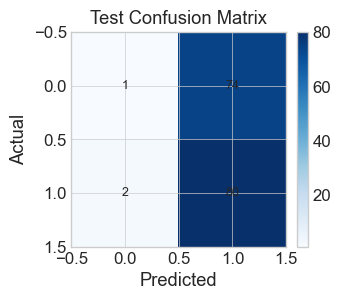

[gate diag] TEST share on=84.0%, off=16.0%


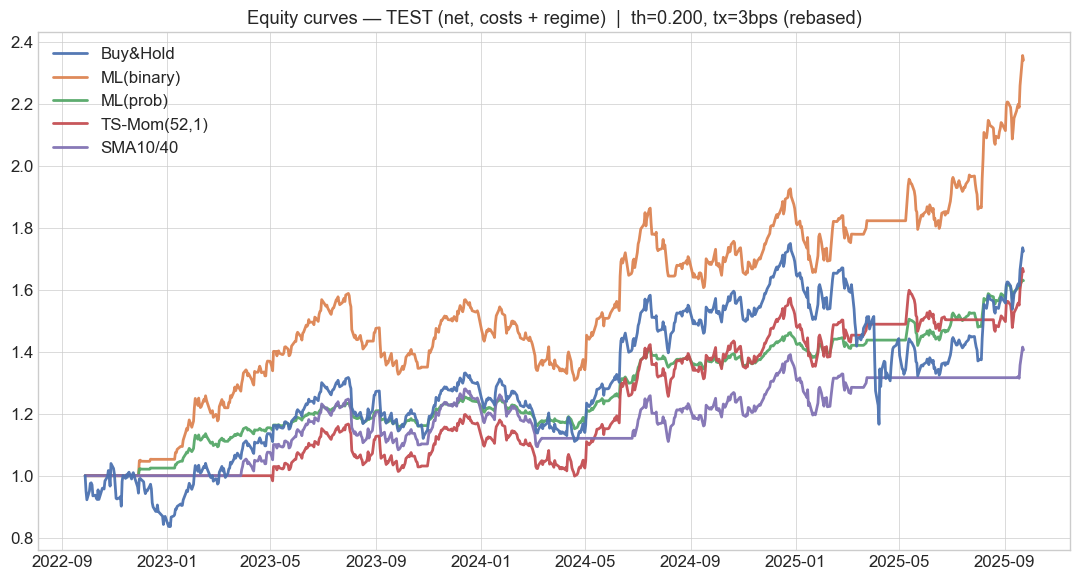

,CAGR,Sharpe,Sortino,MaxDD,Calmar,WinRate
ML(prob),0.1786,1.6511,2.4063,-0.0818,2.1828,0.4619
ML(binary),0.3314,1.4038,2.0100,-0.1766,1.8762,0.4499
"TS-Mom(52,1)",0.1856,0.9205,1.1407,-0.1661,1.1174,0.3738
SMA10/40,0.1215,0.7377,0.7636,-0.1458,0.8329,0.3004
Buy&Hold,0.1962,0.6441,0.9122,-0.3336,0.5880,0.5394


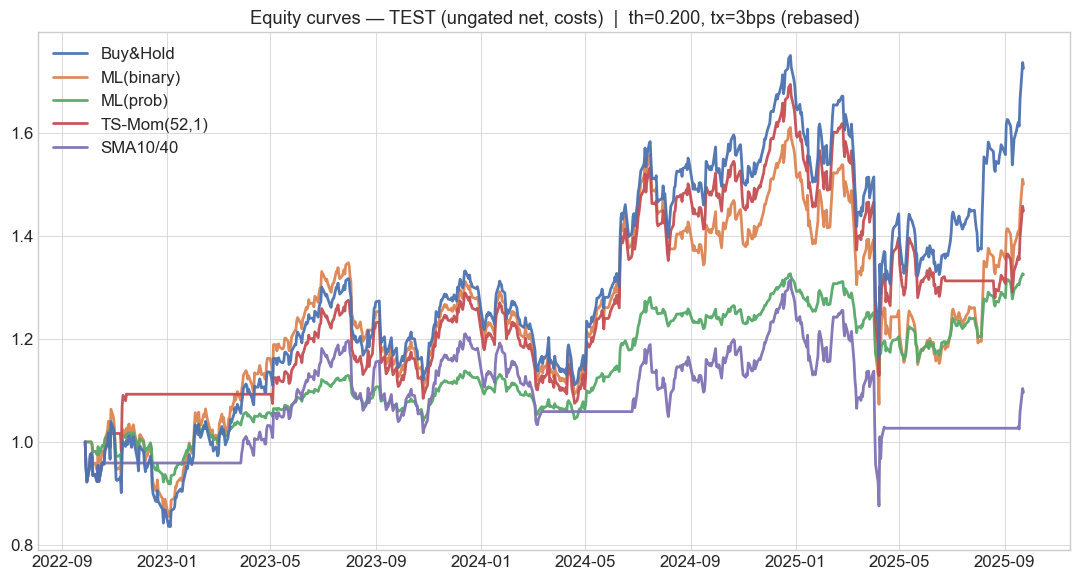

,CAGR,Sharpe,Sortino,MaxDD,Calmar,WinRate
ML(prob),0.0992,0.7358,1.0695,-0.1458,0.6803,0.5354
Buy&Hold,0.1962,0.6441,0.9122,-0.3336,0.5880,0.5394
ML(binary),0.1462,0.5004,0.7045,-0.3336,0.4382,0.5167
"TS-Mom(52,1)",0.1278,0.4877,0.5882,-0.3336,0.3830,0.4259
SMA10/40,0.0269,0.1255,0.1255,-0.3336,0.0808,0.3284


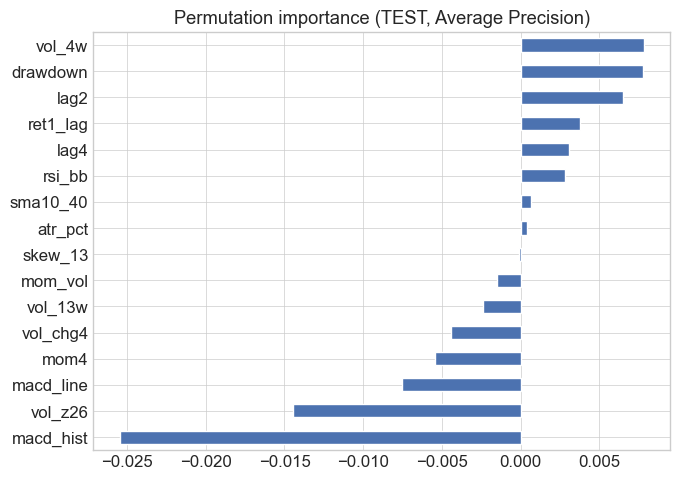

In [7]:
# 6.1 fitting the best model on train predict on test 
final_model = clone(best_model).fit(X_train_val_pruned, y_train_val)

if hasattr(final_model, "predict_proba"):
    proba_test = final_model.predict_proba(X_test_pruned)[:, 1]
else:
    d = final_model.decision_function(X_test_pruned)
    proba_test = (d - d.min()) / (d.max() - d.min() + 1e-12)

# use the threshold from Step 5 
th = float(BEST_THRESHOLD)
print(f"[Step 6] Using BEST_THRESHOLD from Step 5 = {th:.3f}")

y_pred_test = (proba_test >= th).astype(int)

print("== TEST Classification Report ==")
print(classification_report(y_test, y_pred_test, digits=4))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(3.8, 3.2))
plt.imshow(cm, cmap="Blues"); plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Test Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)
plt.tight_layout(); plt.show()

# 6.2 weekly signal to dailys 
sig_ml_w  = pd.Series(y_pred_test, index=X_test_pruned.index, name="ML_bin").shift(1).dropna()
proba_w   = pd.Series(proba_test, index=X_test_pruned.index, name="proba").shift(1).clip(0,1).dropna()

ret_d = F.as_return_series(ret_daily)                       # daily **log** returns
test_start = pd.to_datetime(X_test_pruned.index.min())

sig_ml_d   = F.to_daily_filled(sig_ml_w, ret_d.index).clip(0, 1)
sig_prob_d = F.to_daily_filled(proba_w,  ret_d.index).clip(0, 1)


mom_w = F.ts_mom_signal_w(weekly["Adj Close"], 52, 1)
sma_w = F.sma_signal_w(weekly["Adj Close"], 10, 40)

sig_mom_d = F.to_daily_filled(mom_w,  ret_d.index)
sig_sma_d = F.to_daily_filled(sma_w,  ret_d.index)
sig_bh_d  = pd.Series(1.0, index=ret_d.index)


#6.4 Gating regime build using  (SPY 200DMA) 
#I also added a warning error in case things dont work so its easy to reproduce 
try:
    spy_d = F.get_daily("SPY", CONFIG["START"], CONFIG["END"])  # <-- use utils
    # use Adj Close and build a proper gate (1 if above 200DMA else 0)
    gate_raw = (spy_d["Adj Close"] > spy_d["Adj Close"].rolling(200).mean()).astype(float)

    # align daily return index, forward fill through the nontrading days
    regime = gate_raw.reindex(ret_d.index).ffill()

    # Used to silently turn NaNs into 1s as before first 200dma so ChatGPT helped with this fix
    first_valid = gate_raw.first_valid_index()
    if first_valid is not None:
        regime.loc[:first_valid] = 0.0
    regime = regime.fillna(0.0).clip(0, 1)

except Exception as e:
    print("[warn] regime build faied:", e)
    regime = pd.Series(1.0, index=ret_d.index)

gate_share = regime.loc[regime.index >= test_start].value_counts(normalize=True).to_dict()
print(f"[gate diag] TEST share on={gate_share.get(1.0,0):.1%}, off={gate_share.get(0.0,0):.1%}")

# 6.5 backtests (GATED and UNGATED) 
tx = CONFIG.get("TX_COST_BPS", 5)

bt_gated = {
    "Buy&Hold"     : F.backtest_from_positions(ret_d, sig_bh_d,  tx_bps=0,  regime=None),   # B&H is ungated by definition
    "ML(binary)"   : F.backtest_from_positions(ret_d, sig_ml_d,  tx_bps=tx, regime=regime),
    "ML(prob)"     : F.backtest_from_positions(ret_d, sig_prob_d, tx_bps=tx, regime=regime),
    "TS-Mom(52,1)" : F.backtest_from_positions(ret_d, sig_mom_d, tx_bps=tx, regime=regime),
    "SMA10/40"     : F.backtest_from_positions(ret_d, sig_sma_d, tx_bps=tx, regime=regime),
}

bt_ungated = {
    "Buy&Hold"     : F.backtest_from_positions(ret_d, sig_bh_d,  tx_bps=0,  regime=None),
    "ML(binary)"   : F.backtest_from_positions(ret_d, sig_ml_d,  tx_bps=tx, regime=None),
    "ML(prob)"     : F.backtest_from_positions(ret_d, sig_prob_d, tx_bps=tx, regime=None),
    "TS-Mom(52,1)" : F.backtest_from_positions(ret_d, sig_mom_d, tx_bps=tx, regime=None),
    "SMA10/40"     : F.backtest_from_positions(ret_d, sig_sma_d, tx_bps=tx, regime=None),
}

# 6.6 plots and performance tables
tbl_gated   = F.plot_and_table(bt_gated,   "Equity curves — TEST (net, costs + regime)", th, tx, test_start)
display(tbl_gated)

tbl_ungated = F.plot_and_table(bt_ungated, "Equity curves — TEST (ungated net, costs)", th, tx, test_start)
display(tbl_ungated)

# 6.7  permutation importance ChatGPT gave me this addition idea
try:
    clf = getattr(final_model, "named_steps", {}).get("clf", final_model)
    if hasattr(clf, "predict_proba") or hasattr(clf, "decision_function"):
        pi = permutation_importance(final_model, X_test_pruned, y_test,
                                    scoring="average_precision",
                                    n_repeats=50, random_state=CONFIG.get("RANDOM_STATE", 42))
        imp = pd.Series(pi.importances_mean, index=X_test_pruned.columns).sort_values()
        plt.figure(figsize=(7,5)); imp.tail(20).plot(kind="barh")
        plt.title("Permutation importance (TEST, Average Precision)")
        plt.tight_layout(); plt.show()
except Exception as e:
    print("Permutation importance skipped:", e)

## Step 7 Robustness and WalkForward

[Step7] Using fixed threshold from Step 5: 0.200 | tx=3 bps


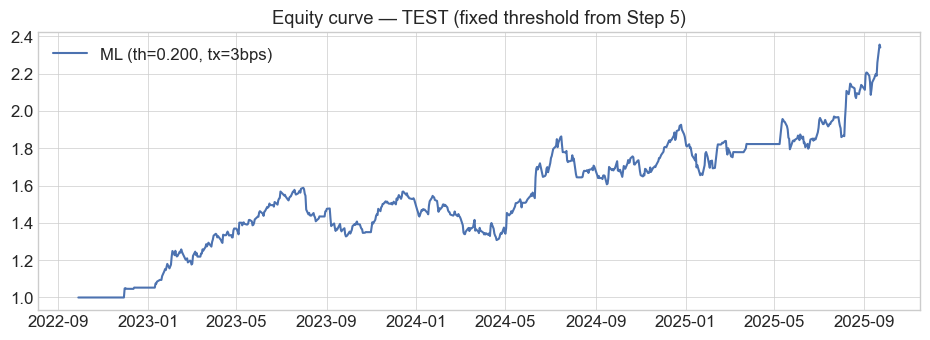

,CAGR,Sharpe,Sortino,MaxDD,Calmar,WinRate
ML (fixed th),0.3314,1.4038,2.01,-0.1766,1.8762,0.4499


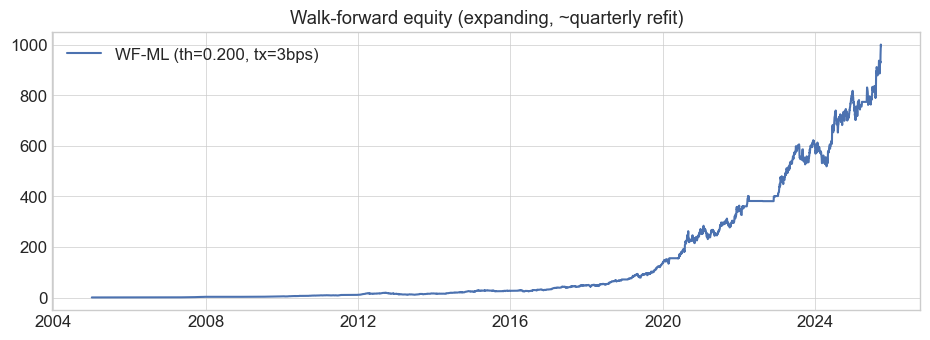

,CAGR,Sharpe,Sortino,MaxDD,Calmar,WinRate
WF-ML (fixed th),0.396,1.4559,1.8399,-0.4221,0.9382,0.4026


In [8]:
#Walkforward analyis to see robustness out of sample
importlib.reload(F)

assert "BEST_THRESHOLD" in globals(), "Run Step 5 first to set BEST_THRESHOLD."
THRESH = float(BEST_THRESHOLD)
TX     = int(CONFIG.get("TX_COST_BPS", 5))
print(f"[Step7] Using fixed threshold from Step 5: {THRESH:.3f} | tx={TX} bps")

# proba on TEST 
if "proba_test" not in globals():
    final_model = clone(best_model).fit(X_train_val_pruned, y_train_val)
    if hasattr(final_model, "predict_proba"):
        proba_test = final_model.predict_proba(X_test_pruned)[:, 1]
    else:
        d = final_model.decision_function(X_test_pruned)
        proba_test = (d - d.min()) / (d.max() - d.min() + 1e-12)

# weekly to daily positions with fixed threshold 
ret_d      = F.as_return_series(ret_daily)
test_start = pd.to_datetime(X_test_pruned.index.min())
proba_w    = pd.Series(proba_test, index=X_test_pruned.index, name="proba").shift(1).clip(0,1).dropna()
sig_w      = (proba_w >= THRESH).astype(float)
sig_d      = F.to_daily_filled(sig_w, ret_d.index)

# reuse regime if presnt else leaves as ungated
regime = regime if "regime" in globals() else pd.Series(1.0, index=ret_d.index)

# TEST backtest 
ret_net = F.backtest_from_positions(ret_d, sig_d, tx_bps=TX, regime=regime)
eq, dd, perf = F.equity_and_perf(ret_net, start_idx=test_start)

plt.figure(figsize=(9.5, 3.6))
plt.plot(eq.loc[eq.index >= test_start], label=f"ML (th={THRESH:.3f}, tx={TX}bps)")
plt.title("Equity curve — TEST (fixed threshold from Step 5)")
plt.legend(); plt.tight_layout(); plt.show()
display(pd.DataFrame(perf, index=["ML (fixed th)"]).round(4))

# Walkforward with trheshold
X_all = pd.concat([X_train_val_pruned, X_test_pruned], axis=0).sort_index()
y_all = pd.concat([y_train_val,        y_test       ], axis=0).sort_index()
weeks = weekly["Adj Close"].index  # weekly index required by the WF helper

wf_sig_w, wf_ret = F.walkforward_backtest(
    best_model, X_all, y_all,
    ret_daily=ret_d,
    weekly_index=weeks,
    regime=regime,
    refit_every_weeks=13,
    threshold=THRESH,
    tx_bps=TX
)

eq_wf, dd_wf, perf_wf = F.equity_and_perf(wf_ret)
plt.figure(figsize=(9.5, 3.6))
plt.plot(eq_wf, label=f"WF-ML (th={THRESH:.3f}, tx={TX}bps)")
plt.title("Walk-forward equity (expanding, ~quarterly refit)")
plt.legend(); plt.tight_layout(); plt.show()
display(pd.DataFrame(perf_wf, index=["WF-ML (fixed th)"]).round(4))


## QuantStats reports from backtests (TEST + Walk-Forward)

In [9]:
#Additional backtests in QF for my report
THRESH   = float(BEST_THRESHOLD)                 
TX_BPS   = int(CONFIG.get("TX_COST_BPS", 3))
USE_GATE = True                                   # True = gated by regime False = ungated


# 1) Make sure I have daily log returns for AAPL as this kept giving errors 
ret_d = F.as_return_series(ret_daily)

# 2) Recomputnmg TEST probabilities and build positions with curent threshold calculated above
final_model = clone(best_model).fit(X_train_val_pruned, y_train_val)
if hasattr(final_model, "predict_proba"):
    proba_test = final_model.predict_proba(X_test_pruned)[:, 1]
else:
    d = final_model.decision_function(X_test_pruned)
    proba_test = (d - d.min())/(d.max()-d.min()+1e-12)

proba_w = pd.Series(proba_test, index=X_test_pruned.index, name="proba").shift(1).clip(0,1).dropna()
pos_w   = (proba_w >= THRESH).astype(float)
pos_d   = F.to_daily_filled(pos_w, ret_d.index)

# regime gate 
reg = regime if (USE_GATE and "regime" in globals()) else None

# 3) Backtest, TEST daily log returns (net of costs)
test_log = F.backtest_from_positions(ret_d, pos_d, tx_bps=TX_BPS, regime=reg)

# 4) Building of simple rturn series for QS and aligning to bennchmark
test_simple = F._to_simple(test_log, f"ML(th={THRESH:.3f}, tx={TX_BPS}bps, {'gated' if USE_GATE else 'ungated'})")
bench_simple_all = F._to_simple(ret_d, name="Buy&Hold")
t0, t1 = test_simple.index.min(), test_simple.index.max()
bench_t = F._clip_bench(bench_simple_all, t0, t1)

print("TEST window:", t0.date(), "→", t1.date(), "| Sharpe (simple):",
      (test_simple.mean()/test_simple.std(ddof=1))*np.sqrt(252))

# 5) Recompute WF 
X_all = pd.concat([X_train_val_pruned, X_test_pruned], axis=0).sort_index()
y_all = pd.concat([y_train_val, y_test], axis=0).sort_index()
weeks = pd.DatetimeIndex(weekly.index).sort_values()

wf_sig_w, wf_ret = F.walkforward_backtest(
    best_model, X_all, y_all,
    ret_daily=ret_d, weekly_index=weeks, regime=reg,
    refit_every_weeks=13, threshold=THRESH, tx_bps=TX_BPS
)
wf_simple = F._to_simple(wf_ret, "ML (WF)")
w0, w1 = wf_simple.index.min(), wf_simple.index.max()
bench_w = F._clip_bench(bench_simple_all, w0, w1)
print("WF   window:", w0.date(), "→", w1.date())

# 6) Save QS HTML
tag = f"{CONFIG['TICKER']}_{THRESH:.3f}_{TX_BPS}bps_{'g' if USE_GATE else 'u'}_{CONFIG['TEST_YEARS']}y"
test_report_path = f"qs_TEST_{tag}.html"
wf_report_path   = f"qs_WF_{tag}.html"

qs.reports.html(
    test_simple,
    benchmark=bench_t.to_frame("Buy&Hold"),
    title=f"TEST: ML vs Buy&Hold ({tag})",
    match_dates=True,
    output=test_report_path
)
qs.reports.html(
    wf_simple,
    benchmark=bench_w.to_frame("Buy&Hold"),
    title=f"Walk-Forward: ML vs Buy&Hold ({tag})",
    match_dates=True,
    output=wf_report_path
)

print(f"\nSaved QuantStats reports:\n  • {test_report_path}\n  • {wf_report_path}")


TEST window: 2005-01-04 → 2025-09-23 | Sharpe (simple): 0.5668964520050088
WF   window: 2005-01-04 → 2025-09-23

Saved QuantStats reports:
  • qs_TEST_AAPL_0.200_3bps_g_3y.html
  • qs_WF_AAPL_0.200_3bps_g_3y.html


## Saving all data used as an excel file

In [10]:
# Save all download data to Excel as Binh Mentioned in forum
# Timestamed filename 
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_path = os.path.join(CONFIG["OUT_DIR"], f"{CONFIG['TICKER']}_data_{timestamp}.xlsx")

# Save all DF to separate sheets
with pd.ExcelWriter(output_path) as writer:  
    AAPL_DAILY.to_excel(writer, sheet_name="AAPL_Daily")
    AAPL_WEEKLY.to_excel(writer, sheet_name="AAPL_Weekly")
    RET_DAILY.to_excel(writer, sheet_name="AAPL_Daily_Returns")
    
    if not PEER_RET_W.empty:
        PEER_RET_W.to_excel(writer, sheet_name="Peer_ETF_Weekly_Returns")
    
    # Add config for reproducblity
    pd.DataFrame.from_dict(CONFIG, orient="index", columns=["Value"]).to_excel(writer, sheet_name="Config")

# --------------------------------------------------------------
# STEP — Export ML Test Results for Deep Learning comparison
# --------------------------------------------------------------

import os

# Choose which table to export — in your project you already compute:
#   tbl_ungated = F.plot_and_table(bt_ungated, ...)
#   tbl_gated   = F.plot_and_table(bt_gated, ...)
# We'll use the ungated table for fairness (you can change this if you prefer).
ml_results = tbl_ungated.copy()

# Add metadata columns to help when comparing later
ml_results.insert(0, "Model", "Best_ML_Model")
ml_results["Config_Ticker"] = CONFIG["TICKER"]
ml_results["Test_Years"] = CONFIG["TEST_YEARS"]

# Save to your outputs folder
output_dir = r"C:\Users\ashyl\Desktop\BFF5555\Assesments\Individual Project\outputs"
ml_csv_path = os.path.join(output_dir, "ml_test_results.csv")

ml_results.to_csv(ml_csv_path, index=True)
print(f"✅ ML test results exported successfully:\n   {ml_csv_path}")
display(ml_results.head())


✅ ML test results exported successfully:
   C:\Users\ashyl\Desktop\BFF5555\Assesments\Individual Project\outputs\ml_test_results.csv


,Model,CAGR,Sharpe,Sortino,MaxDD,Calmar,WinRate,Config_Ticker,Test_Years
ML(prob),Best_ML_Model,0.0992,0.7358,1.0695,-0.1458,0.6803,0.5354,AAPL,3
Buy&Hold,Best_ML_Model,0.1962,0.6441,0.9122,-0.3336,0.5880,0.5394,AAPL,3
ML(binary),Best_ML_Model,0.1462,0.5004,0.7045,-0.3336,0.4382,0.5167,AAPL,3
"TS-Mom(52,1)",Best_ML_Model,0.1278,0.4877,0.5882,-0.3336,0.3830,0.4259,AAPL,3
SMA10/40,Best_ML_Model,0.0269,0.1255,0.1255,-0.3336,0.0808,0.3284,AAPL,3


In [11]:
# --------------------------------------------------------------
# STEP — Export ML CLASSIFICATION METRICS for Deep Learning Comparison
# --------------------------------------------------------------
import os
import pandas as pd
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score
)

# Confirm that best_model, X_test_pruned, and y_test exist
if all(v in globals() for v in ["best_model", "X_test_pruned", "y_test"]):
    print("✅ Exporting metrics for your best traditional ML model...")

    # Predict probabilities and classes
    if hasattr(best_model, "predict_proba"):
        proba_ml = best_model.predict_proba(X_test_pruned)[:, 1]
    else:
        d = best_model.decision_function(X_test_pruned)
        proba_ml = (d - d.min()) / (d.max() - d.min() + 1e-12)
    y_pred_ml = (proba_ml >= 0.5).astype(int)

    # Compute key metrics
    ml_metrics = {
        "AUC": roc_auc_score(y_test, proba_ml),
        "Precision": precision_score(y_test, y_pred_ml),
        "Recall": recall_score(y_test, y_pred_ml),
        "Accuracy": accuracy_score(y_test, y_pred_ml)
    }

    ml_results_df = pd.DataFrame(ml_metrics, index=["Test"])
    ml_results_df["Model"] = "Best_ML_Model"

    # Save to same folder as your outputs
    out_dir = r"C:\Users\ashyl\Desktop\BFF5555\Assesments\Individual Project\outputs"
    ml_results_path = os.path.join(out_dir, "ml_test_results.csv")

    ml_results_df.to_csv(ml_results_path)
    print(f"✅ Exported comparable ML metrics to:\n{ml_results_path}")
    display(ml_results_df)

else:
    print("[!] Required variables not found. Make sure to run your model training section first.")


✅ Exporting metrics for your best traditional ML model...
✅ Exported comparable ML metrics to:
C:\Users\ashyl\Desktop\BFF5555\Assesments\Individual Project\outputs\ml_test_results.csv


,AUC,Precision,Recall,Accuracy,Model
Test,0.529919,0.59322,0.426829,0.547771,Best_ML_Model


In [12]:
# --------------------------------------------------------------
# SAVE TEST PROBABILITIES FOR LSTM COMPARISON
# --------------------------------------------------------------
# Only run this in your Individual Project notebook (not the LSTM one)

if hasattr(final_model, "predict_proba"):
    proba_test = final_model.predict_proba(X_test_pruned)[:, 1]
else:
    d = final_model.decision_function(X_test_pruned)
    proba_test = (d - d.min()) / (d.max() - d.min() + 1e-12)

# Save as CSV for Deep Learning comparison
out = pd.DataFrame({
    "proba": proba_test,
    "y_true": y_test.values
}, index=X_test_pruned.index)
out.to_csv(r"C:\Users\ashyl\Desktop\BFF5555\Assesments\Individual Project\outputs\ml_test_predictions.csv")

print("✅ Saved ML test probabilities for LSTM comparison.")


✅ Saved ML test probabilities for LSTM comparison.
